In [1]:
### Importando bibliotecas ###
import osmnx as ox # OpenStreetMap: biblioteca de mapas
import networkx as nx # para trabalhar com grafos
import folium # para criar mapas interativos
import matplotlib.pyplot as plt # para visualização
import numpy as np # para cálculo numérico
import seaborn as sns # para visualização
import pyomo.environ as pyo


# Primeiro vamos gerar um grafo a partir do mapa de uma região 

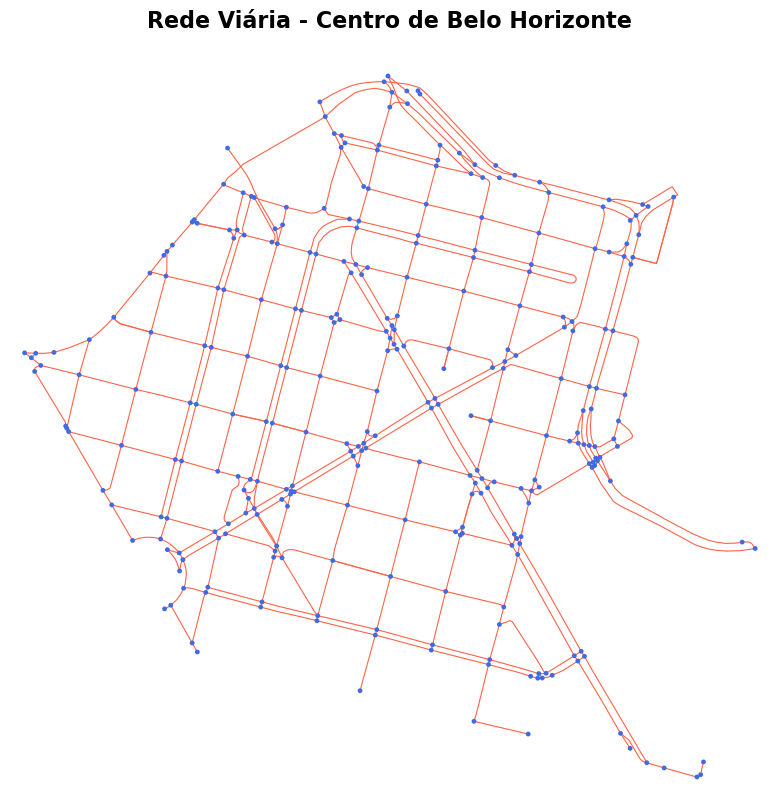

In [2]:

# Definindo a região escolhida
regiao = "Centro, Belo Horizonte, Minas Gerais, Brazil"

# Fazer download do grafo real da região 
G = ox.graph_from_place(regiao, network_type="drive")

# vamos plotar o grafo obtido
fig, ax = ox.plot_graph(
    G,
    node_size=12,
    node_color="royalblue",
    edge_color="tomato",
    bgcolor="white",
    edge_linewidth=0.8,
    show=False,   
    close=False,  
)

ax.set_title(
    "Rede Viária - Centro de Belo Horizonte",
    fontsize=16,
    fontweight="bold",
    color="black",
    pad=25,
)

plt.tight_layout()
plt.subplots_adjust(top=0.93)

plt.show()


# Vamos criar um mapa interativo 

In [3]:

# Vamos extrair os nós e as arestas
nodes, edges = ox.graph_to_gdfs(G)

# para centralizar o mapa
centro = [nodes.geometry.y.mean(), nodes.geometry.x.mean()]

# Cria o mapa base com a biblioteca Folium
m = folium.Map(location=centro, zoom_start=14, tiles="cartodbpositron")

# Adicionando as arestas (ruas)
for _, row in edges.iterrows():
    pontos = [(y, x) for x, y in row.geometry.coords]
    folium.PolyLine(pontos, color="gray", weight=2, opacity=0.8).add_to(m)

# Adicionando os nós (interseções)
for _, row in nodes.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=2,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7
    ).add_to(m)

# Salva o mapa 
m.save("mapa.html")

# Vamos escolher 4 locais aleatórios.
# Estes locais serão pontos de que serão atendidos por um centro de distribuição.

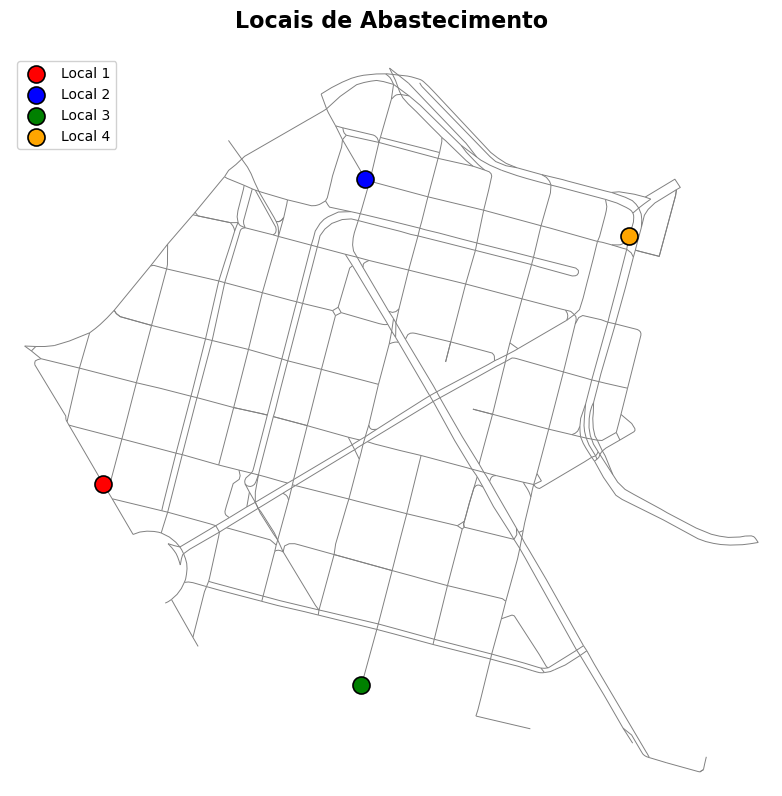

In [4]:

nos = list(G.nodes())

# definindo a semente
np.random.seed(54)

locais_atendimento = np.random.choice(nos, 4)

# Plotando o grafo base 
fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    node_size=0,  # Remove os pontos dos nós da rede
    edge_linewidth=0.7,  
    edge_color='gray',  # Cor para as ruas
    bgcolor='white'
)

# Plotando os 4 locais escolhidos
cores = ['red', 'blue', 'green', 'orange']
rotulos = ['Local 1', 'Local 2', 'Local 3', 'Local 4']

for i, no in enumerate(locais_atendimento):
    coordenadas = G.nodes[no]
    ax.scatter(coordenadas['x'], coordenadas['y'], 
               c=cores[i], s=150, zorder=5, 
               label=rotulos[i], edgecolors='black', 
               linewidth=1.2, marker='o')  # marker 'o' para círculo

# Melhorando a legenda
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)

# Título
fig.suptitle(
    "Locais de Abastecimento",
    fontsize=16,
    fontweight='bold',
    y=0.99
)

plt.tight_layout()
plt.show()



# Agora precisamos saber onde será o local do Centro de Distribuição

In [5]:

# Função que encontra o local mais estratégico dado os locais escolhidos e o grafo da região 
def encontrar_centro_distribuicao(locais_escolhidos, Grafo):
    """Encontra o melhor local para centro de distribuição que minimiza 
    a soma das distâncias para todos os locais escolhidos"""

    # Calcular todas as distâncias de uma vez
    todas_distancias = dict(nx.all_pairs_dijkstra_path_length(Grafo, weight='length'))
    
    melhor_no = None
    menor_soma = float('inf')
    melhores_distancias = []
    
    # Analisar cada nó do grafo
    for no in Grafo.nodes():
        soma = 0
        distancias = []
        
        for local in locais_escolhidos:
            if no == local:
                distancia = 0
            else:
                distancia = todas_distancias[no].get(local, float('inf'))
            distancias.append(distancia)
            soma += distancia
        
        # Atualizar melhor nó se encontrou uma soma menor
        if soma < menor_soma:
            menor_soma = soma
            melhor_no = no
            melhores_distancias = distancias
    
    
    return melhor_no


print("O melhor local para o CD é:", encontrar_centro_distribuicao(locais_atendimento, G))

O melhor local para o CD é: 2931009202


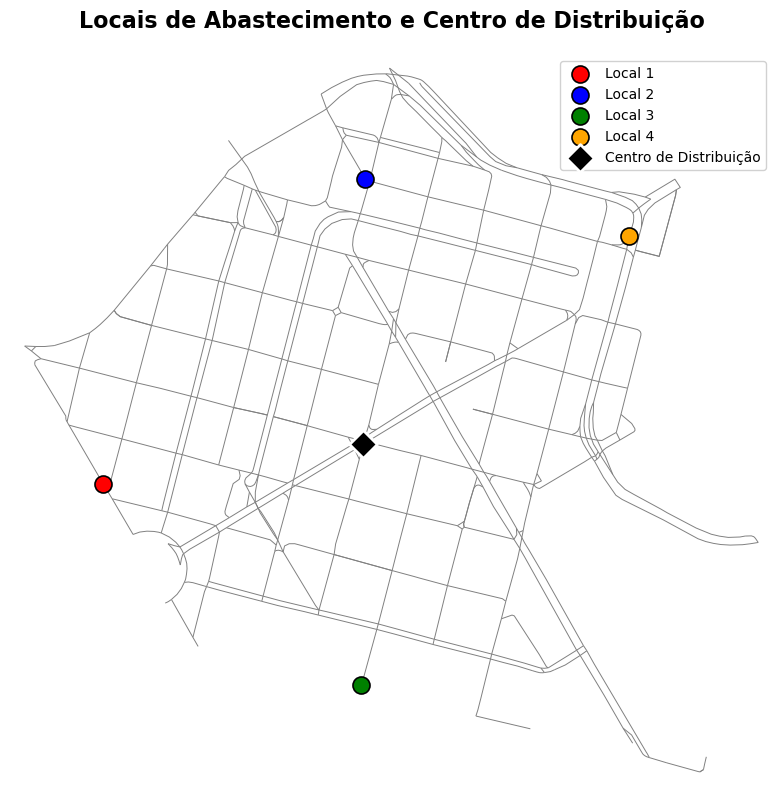

In [6]:
# Centro de distribuição escolhido
cd_escolhido = encontrar_centro_distribuicao(locais_atendimento, G)

# Plotando o grafo base (sem rota)
fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    node_size=0,  # Remove os pontos dos nós da rede
    edge_linewidth=0.7,  
    edge_color='gray',  # Cor para as ruas
    bgcolor='white'
)

# Plotando os 4 locais escolhidos
cores = ['red', 'blue', 'green', 'orange']
rotulos = ['Local 1', 'Local 2', 'Local 3', 'Local 4']

for i, no in enumerate(locais_atendimento):
    coordenadas = G.nodes[no]
    ax.scatter(coordenadas['x'], coordenadas['y'], 
               c=cores[i], s=150, zorder=5, 
               label=rotulos[i], edgecolors='black', 
               linewidth=1.2, marker='o')  # marker 'o' para círculo

# Plotando o Centro de Distribuição
coordenadas_cd = G.nodes[cd_escolhido]
ax.scatter(coordenadas_cd['x'], coordenadas_cd['y'], 
           c='black', s=200, zorder=6, 
           label='Centro de Distribuição', edgecolors='white', 
           linewidth=2, marker='D')  # marker '*' para estrela

# Melhorando a legenda
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

# Título
fig.suptitle(
    "Locais de Abastecimento e Centro de Distribuição",
    fontsize=16,
    fontweight='bold',
    y=0.99
)

plt.tight_layout()
plt.show()

# Vamos plotar todas as melhores rotas 

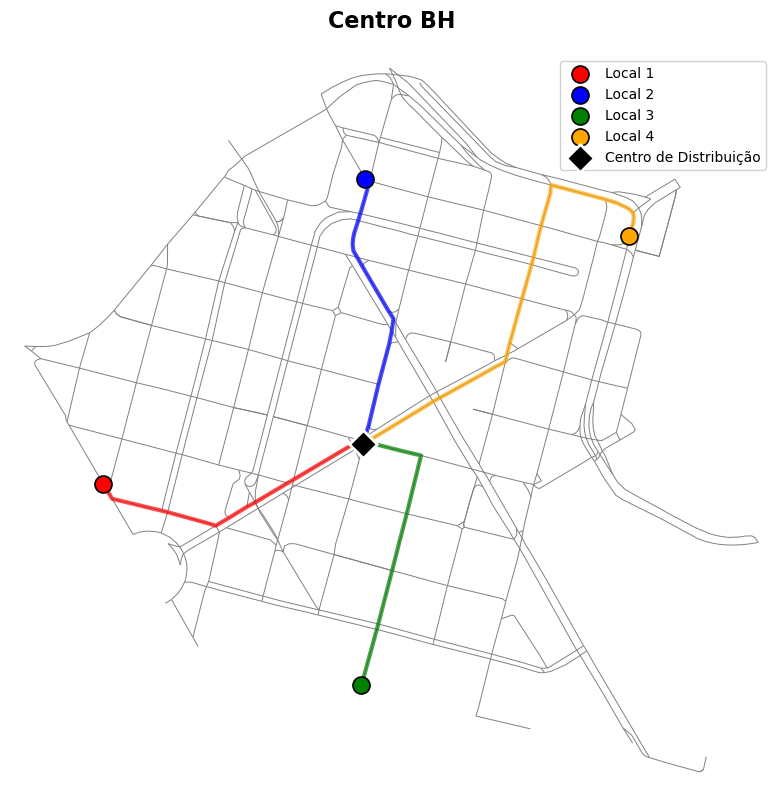

In [7]:

# Plotando o grafo base (sem rotas)
fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    node_size=0,  # Remove os pontos dos nós da rede
    edge_linewidth=0.7,  
    edge_color='gray',  # Cor para as ruas
    bgcolor='white'
)

# Cores para os caminhos
cores_caminhos = ['red', 'blue', 'green', 'orange']
rotulos = ['Local 1', 'Local 2', 'Local 3', 'Local 4']

# Plotar os caminhos mais curtos do CD para cada local
for i, local in enumerate(locais_atendimento):
    # Calcular o caminho mais curto
    caminho = nx.shortest_path(G, cd_escolhido, local, weight='length')
    
    # Plotar o caminho
    ox.plot_graph_route(
        G, 
        caminho, 
        route_color=cores_caminhos[i],
        route_linewidth=3,
        route_alpha=0.7,
        orig_dest_size=0,  # Não plotar marcadores de origem/destino
        ax=ax,
        show=False,
        close=False
    )

# Plotando os 4 locais escolhidos
for i, no in enumerate(locais_atendimento):
    coordenadas = G.nodes[no]
    ax.scatter(coordenadas['x'], coordenadas['y'], 
               c=cores_caminhos[i], s=150, zorder=5, 
               label=rotulos[i], edgecolors='black', 
               linewidth=1.2, marker='o')  # marker 'o' para círculo

# Plotando o Centro de Distribuição
coordenadas_cd = G.nodes[cd_escolhido]
ax.scatter(coordenadas_cd['x'], coordenadas_cd['y'], 
           c='black', s=200, zorder=6, 
           label='Centro de Distribuição', edgecolors='white', 
           linewidth=2, marker='D')  # marker 'D' para diamante


ax.legend(loc='upper right', fontsize=10, framealpha=0.9)


fig.suptitle(
    "Centro BH",
    fontsize=16,
    fontweight='bold',
    y=0.99
)

plt.tight_layout()
plt.show()



# para que possamos criar um problema de otimização logística, iremos adicionar um novo CD à mão mesmo. 

In [8]:

novo_CD = np.random.choice(nos)


# Vamos plotar todas as melhores rotas com o novo CD 

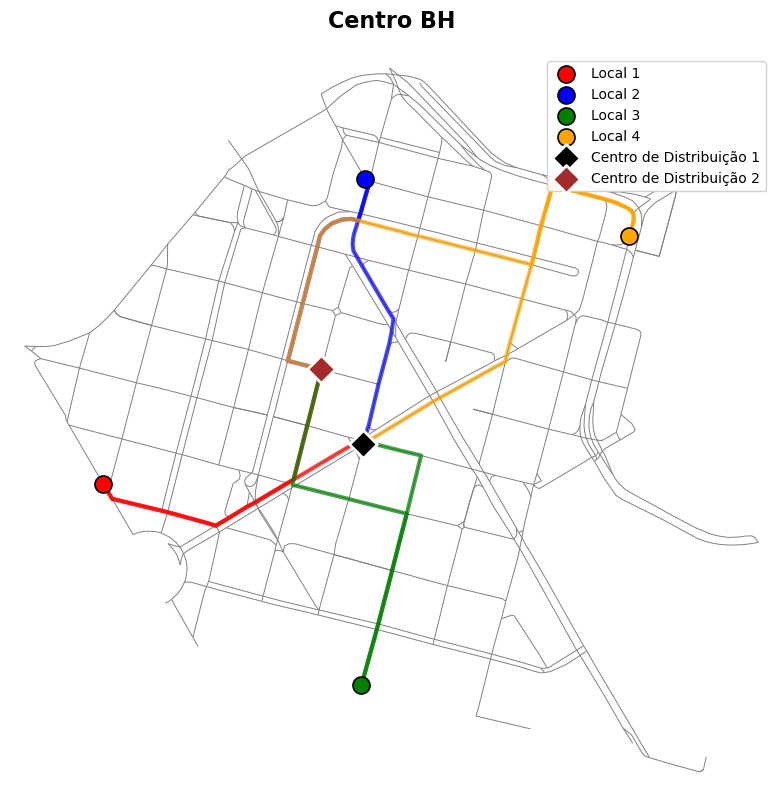

In [9]:


# Plotando o grafo base 
fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    node_size=0,  # Remove os pontos dos nós da rede
    edge_linewidth=0.7,  
    edge_color='gray',  # Cor para as ruas
    bgcolor='white'
)

# Cores para os caminhos
cores_caminhos = ['red', 'blue', 'green', 'orange']
rotulos = ['Local 1', 'Local 2', 'Local 3', 'Local 4']

# Plotar os caminhos mais curtos do CD para cada local
for i, local in enumerate(locais_atendimento):
    # Calcular o caminho mais curto
    caminho = nx.shortest_path(G, cd_escolhido, local, weight='length')
    
    # Plotar o caminho
    ox.plot_graph_route(
        G, 
        caminho, 
        route_color=cores_caminhos[i],
        route_linewidth=3,
        route_alpha=0.7,
        orig_dest_size=0,  # Não plotar marcadores de origem/destino
        ax=ax,
        show=False,
        close=False
    )
    
    
    
# Plotar os caminhos mais curtos do novo CD para cada local
for i, local in enumerate(locais_atendimento):
    # Calcular o caminho mais curto
    caminho = nx.shortest_path(G, novo_CD, local, weight='length')
    
    # Plotar o caminho
    ox.plot_graph_route(
        G, 
        caminho, 
        route_color=cores_caminhos[i],
        route_linewidth=3,
        route_alpha=0.7,
        orig_dest_size=0,  # Não plotar marcadores de origem/destino
        ax=ax,
        show=False,
        close=False
    )

# Plotando os 4 locais escolhidos
for i, no in enumerate(locais_atendimento):
    coordenadas = G.nodes[no]
    ax.scatter(coordenadas['x'], coordenadas['y'], 
               c=cores_caminhos[i], s=150, zorder=5, 
               label=rotulos[i], edgecolors='black', 
               linewidth=1.2, marker='o')  # marker 'o' para círculo

# Plotando o Centro de Distribuição
coordenadas_cd = G.nodes[cd_escolhido]
ax.scatter(coordenadas_cd['x'], coordenadas_cd['y'], 
           c='black', s=200, zorder=6, 
           label='Centro de Distribuição 1', edgecolors='white', 
           linewidth=2, marker='D')  # marker 'D' para diamante


# Plotando o Centro de Distribuição
coordenadas_cd = G.nodes[novo_CD]
ax.scatter(coordenadas_cd['x'], coordenadas_cd['y'], 
           c='brown', s=200, zorder=6, 
           label='Centro de Distribuição 2', edgecolors='white', 
           linewidth=2, marker='D')  # marker 'D' para diamante


ax.legend(loc='upper right', fontsize=10, framealpha=0.9)


fig.suptitle(
    "Centro BH",
    fontsize=16,
    fontweight='bold',
    y=0.99
)

plt.tight_layout()
plt.show()


# Vamos guardar a distância do CD1 para cada Local 

In [10]:


distancia_CD1_locais = np.zeros(4)
for i in range(4):
    distancia_CD1_locais[i] = nx.shortest_path_length(G, cd_escolhido, 
                                                     locais_atendimento[i], weight='length')
    
    
print(distancia_CD1_locais)

[ 728.17143332  678.94569371  708.98877631 1092.0464999 ]


# Vamos guardar a distância do CD2 para cada Local 

In [11]:


distancia_CD2_locais = np.zeros(4)
for i in range(4):
    distancia_CD2_locais[i] = nx.shortest_path_length(G, novo_CD, 
                                                     locais_atendimento[i], weight='length')
    
    
print(distancia_CD2_locais)

[ 781.47237429  605.67387653  986.35502585 1382.5689442 ]


# Agora, vamos fazer a distribuição para cada local de acordo com sua demanda. Iremos implementar um modelo que otimiza as entregas, diminuindo os gastos com logística e, consequentemente, aumentando os lucros. 

In [12]:

# a demanda para cada local é:
# Local 1 => 115; Local 2 => 50; Local 3 => 165; Local 4 => 70
demanda = [115, 50, 165, 70]
n = len(demanda)

# a capacidade de cada CD
# CD1 => 250; CD2 => 150
capacidade = [250, 150]
m = len(capacidade)

# o custo de enviar de um CD para um local é a distancia * custo por metro

cm = 0.1 # custo por metro é de R$ 0.1 
custos = [distancia_CD1_locais * cm, distancia_CD2_locais * cm] 





# Nosso objetivo é satisfazer todas as demandas da forma mais eficiente, ou seja, queremos minimizar os custos da entrega para isso vamos utilizar a biblioteca Pyomo com o solver GLPK para otimização. 


In [13]:
# declaração do modelo
modelo = pyo.ConcreteModel()

# Índices
modelo.I = pyo.RangeSet(m)
modelo.J = pyo.RangeSet(n)

# Parâmetros 
modelo.c = pyo.Param(modelo.I, modelo.J, initialize=lambda modelo, i, j: custos[i-1][j-1])
modelo.a = pyo.Param(modelo.I, initialize=lambda modelo, i: capacidade[i-1])
modelo.b = pyo.Param(modelo.J, initialize=lambda modelo, j: demanda[j-1])


# Variáveis de decisão:
modelo.x = pyo.Var(modelo.I, modelo.J, within=pyo.NonNegativeReals)


# Função objetivo:
def regra_z(mod):
    return pyo.summation(mod.c, mod.x)


modelo.z = pyo.Objective(rule=regra_z, sense=pyo.minimize) 


# Restrições:
def regra_capacidade(mod, i):
    return sum(mod.x[i,j] for j in mod.J) <= mod.a[i]

modelo.restr_capacidade = pyo.Constraint(modelo.I, rule=regra_capacidade)

def regra_demanda(mod, j):
    return sum(mod.x[i,j] for i in mod.I) >= mod.b[j]

modelo.restr_demanda = pyo.Constraint(modelo.J, rule=regra_demanda)

# O modelo implementado faz o seguinte:

### Nossa Função Objetivo
Minimizar o custo total de transporte:

$$
\min z = \sum_{i=1}^{m} \sum_{j=1}^{n} c_{ij} \cdot x_{ij}
$$

### Restrições

1. Capacidade dos fornecedores não pode exceder a capacidade de cada origem $i$:

$$
\sum_{j=1}^{n} x_{ij} \leq a_i \quad \forall i \in \{1,2,...,m\}
$$

2. Atendimento à demanda (satisfazer a demanda de cada destino $j$):

$$
\sum_{i=1}^{m} x_{ij} \geq b_j \quad \forall j \in \{1,2,...,n\}
$$

3. Não-negatividade:

$$
x_{ij} \geq 0 \quad \forall i,j
$$

## Estrutura do Problema

- Variáveis de decisão: $x_{ij}$ = quantidade transportada da origem $i$ para o destino $j$
- Parâmetros:
  - $c_{ij}$ = custo unitário de transporte de $i$ para $j$
  - $a_i$ = capacidade da origem $i$
  - $b_j$ = demanda do destino $j$

## Características do Modelo

- Problema de **programação linear**
- Pode ser aplicado para problemas com demandas maiores

In [14]:

solver = pyo.SolverFactory('glpk', executable='/usr/bin/glpsol')

resultado = solver.solve(modelo)

In [15]:
modelo.x.pprint()

x : Size=8, Index=I*J
    Key    : Lower : Value : Upper : Fixed : Stale : Domain
    (1, 1) :     0 :  15.0 :  None : False : False : NonNegativeReals
    (1, 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
    (1, 3) :     0 : 165.0 :  None : False : False : NonNegativeReals
    (1, 4) :     0 :  70.0 :  None : False : False : NonNegativeReals
    (2, 1) :     0 : 100.0 :  None : False : False : NonNegativeReals
    (2, 2) :     0 :  50.0 :  None : False : False : NonNegativeReals
    (2, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
    (2, 4) :     0 :   0.0 :  None : False : False : NonNegativeReals


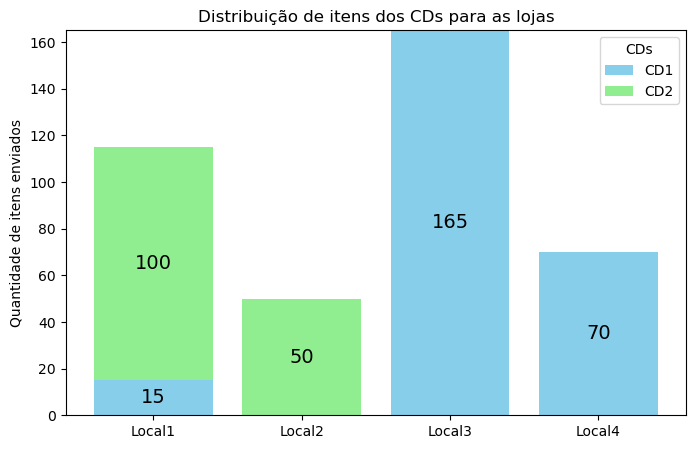

In [16]:
# Preparar dados
lojas = [f"Local{j}" for j in modelo.J]
cds = [f"CD{i}" for i in modelo.I]

# Criar matriz de quantidades CD x Loja
quantidades = np.zeros((m, n))
for i in modelo.I:
    for j in modelo.J:
        quantidades[i-1, j-1] = modelo.x[i,j].value

# Plot de barras empilhadas
fig, ax = plt.subplots(figsize=(8,5))

bottom = np.zeros(n)  # para empilhar barras
colors = ['skyblue', 'lightgreen', 'salmon', 'orange']

for i in range(m):
    bars = ax.bar(lojas, quantidades[i], bottom=bottom, label=cds[i], color=colors[i % len(colors)])
    
    # Adicionar os valores nas barras
    for bar, quantidade, b in zip(bars, quantidades[i], bottom):
        if quantidade > 0:
            ax.text(bar.get_x() + bar.get_width()/2, b + quantidade/2, f'{int(quantidade)}',
                    ha='center', va='center', color='black', fontsize=14)
    
    bottom += quantidades[i]

ax.set_ylabel("Quantidade de itens enviados")
ax.set_title("Distribuição de itens dos CDs para as lojas")
ax.legend(title="CDs")
plt.show()